In [220]:
# import libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix, roc_curve, f1_score, recall_score

from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns

In [221]:
# download data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00468/online_shoppers_intention.csv"
data = pd.read_csv(url)

# data overview
print("data samples")
print(data.head())
print("\ndata info")
print(data.info())

data samples
   Administrative  Administrative_Duration  Informational  \
0               0                      0.0              0   
1               0                      0.0              0   
2               0                      0.0              0   
3               0                      0.0              0   
4               0                      0.0              0   

   Informational_Duration  ProductRelated  ProductRelated_Duration  \
0                     0.0               1                 0.000000   
1                     0.0               2                64.000000   
2                     0.0               1                 0.000000   
3                     0.0               2                 2.666667   
4                     0.0              10               627.500000   

   BounceRates  ExitRates  PageValues  SpecialDay Month  OperatingSystems  \
0         0.20       0.20         0.0         0.0   Feb                 1   
1         0.00       0.10         0.0        

In [222]:
ADMINISTRATIVE = 'Administrative'
ADMINISTRATIVE_DURATION = 'Administrative_Duration'
INFORMATIONAL = 'Informational'
INFORMATIONAL_DURATION = 'Informational_Duration'
PRODUCTRELATED = 'ProductRelated'
PRODUCTRELATED_DURATION = 'ProductRelated_Duration'
BOUNCERATES = 'BounceRates'
EXITRATES = 'ExitRates'
PAGEVALUES = 'PageValues'
SPECIALDAY = 'SpecialDay'
MONTH = 'Month'
OPERATINGSYSTEMS = 'OperatingSystems'
BROWSER = 'Browser'
REGION = 'Region'
TRAFFICTYPE = 'TrafficType'
VISITORTYPE = 'VisitorType'
WEEKEND = 'Weekend'
REVENUE = 'Revenue'

<ipython-input-223-2bd7110db868>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data[REVENUE], palette="coolwarm", ax=axes[0, 0])
<ipython-input-223-2bd7110db868>:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].set_xticklabels(['Not Purchased (False)', 'Purchased (True)'])
<ipython-input-223-2bd7110db868>:30: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data[data[REVENUE] == 0], x=BOUNCERATES, label='No Purchase', shade=True, ax=axes[1, 1])
<ipython-input-223-2bd7110db868>:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; pleas

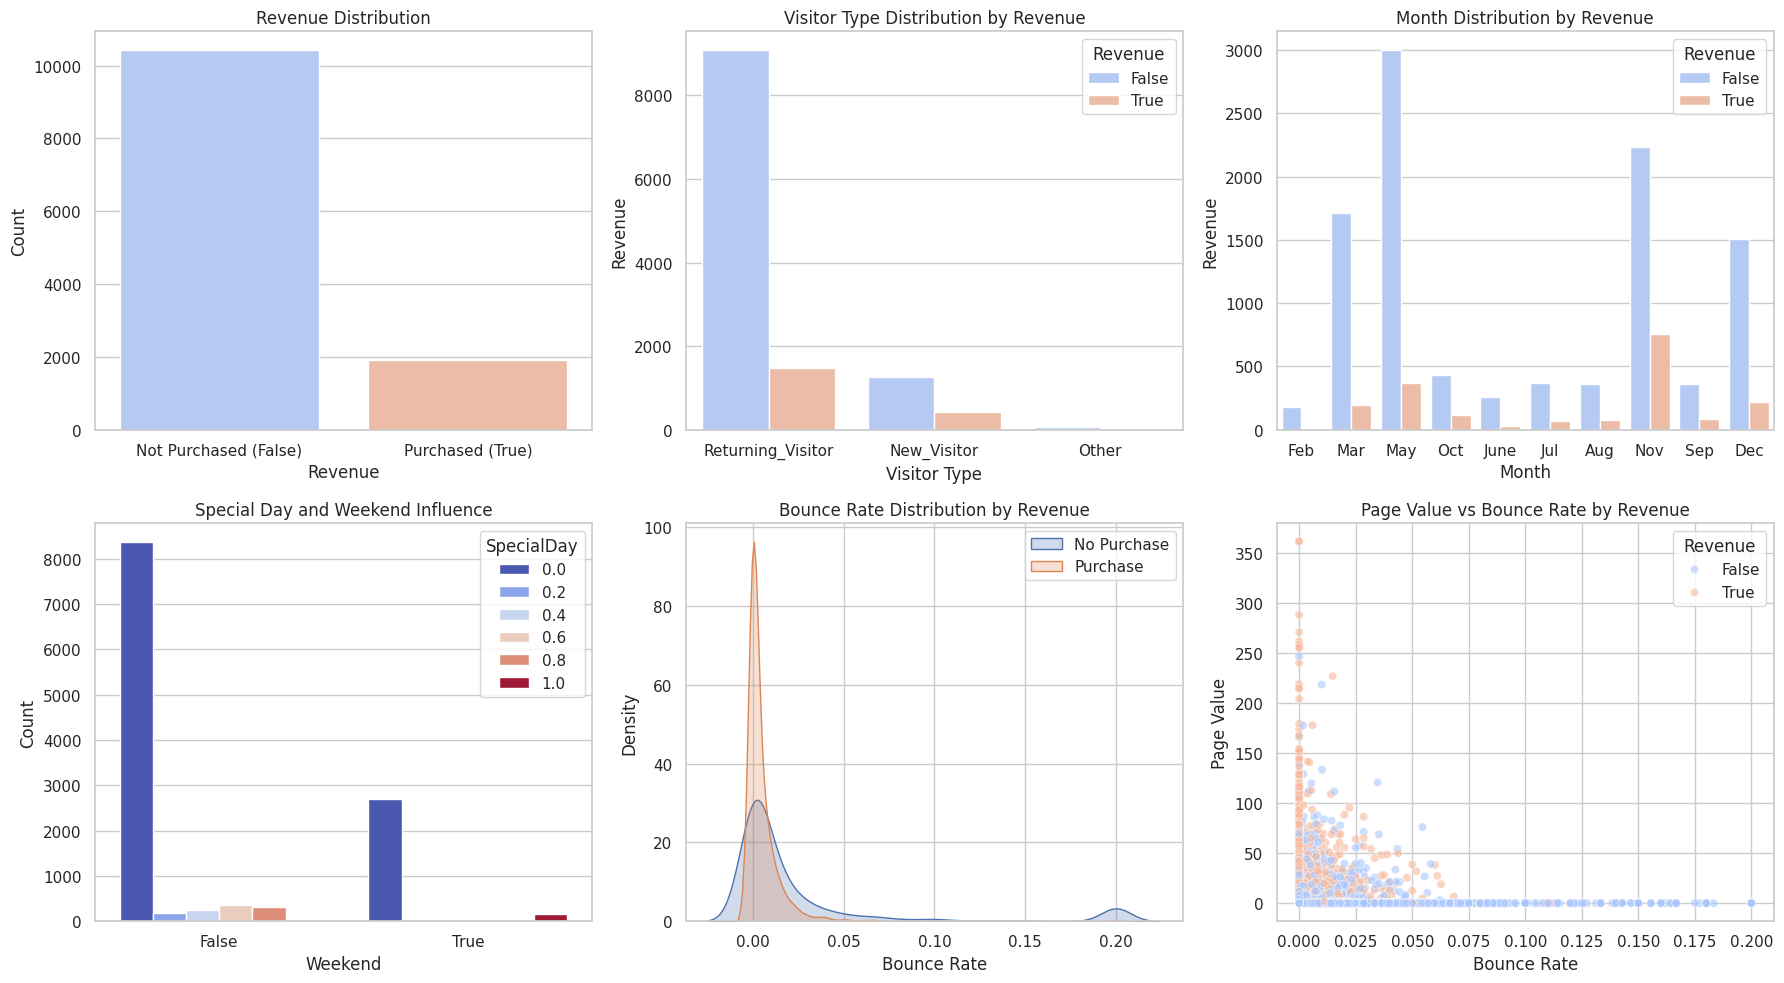

In [223]:
# exploratory data analysis
sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
# data visualization: distribution of Revenue
sns.countplot(x=data[REVENUE], palette="coolwarm", ax=axes[0, 0])
axes[0, 0].set_title("Revenue Distribution")
axes[0, 0].set_xticklabels(['Not Purchased (False)', 'Purchased (True)'])
axes[0, 0].set_xlabel("Revenue")
axes[0, 0].set_ylabel("Count")

# data visualization: Visitor Type Distribution by Revenue
sns.countplot(data=data, x=VISITORTYPE, hue=REVENUE, palette='coolwarm', ax=axes[0, 1])
axes[0, 1].set_title("Visitor Type Distribution by Revenue")
axes[0, 1].set_xlabel("Visitor Type")
axes[0, 1].set_ylabel("Revenue")

# data visualization: Month Distribution by Revenue
sns.countplot(data=data, x=MONTH, hue=REVENUE, palette='coolwarm', ax=axes[0, 2])
axes[0, 2].set_title("Month Distribution by Revenue")
axes[0, 2].set_xlabel("Month")
axes[0, 2].set_ylabel("Revenue")

# data visualization: joint influence by special day and weekend
sns.countplot(data=data, x=WEEKEND, hue=SPECIALDAY, palette='coolwarm', ax=axes[1, 0])
axes[1, 0].set_title("Special Day and Weekend Influence")
axes[1, 0].set_xlabel("Weekend")
axes[1, 0].set_ylabel("Count")

# data visualization: Bounce Rate Distribution
sns.kdeplot(data=data[data[REVENUE] == 0], x=BOUNCERATES, label='No Purchase', shade=True, ax=axes[1, 1])
sns.kdeplot(data=data[data[REVENUE] == 1], x=BOUNCERATES, label='Purchase', shade=True, ax=axes[1, 1])
axes[1, 1].set_title("Bounce Rate Distribution by Revenue")
axes[1, 1].set_xlabel("Bounce Rate")
axes[1, 1].set_ylabel("Density")
axes[1, 1].legend()

# data visualization: Page Value vs Bounce Rate
sns.scatterplot(data=data, x=BOUNCERATES, y=PAGEVALUES, hue=REVENUE, palette='coolwarm', alpha=0.6, ax=axes[1, 2])
axes[1, 2].set_title("Page Value vs Bounce Rate by Revenue")
axes[1, 2].set_xlabel("Bounce Rate")
axes[1, 2].set_ylabel("Page Value")

plt.tight_layout()
plt.show()

In [224]:
# data preprocessing & encode data
# initialize encoder
label_encoder = LabelEncoder()

# encode Month, VisitorType, Weekend, Revenue column
data[MONTH] = label_encoder.fit_transform(data[MONTH])
data[VISITORTYPE] = label_encoder.fit_transform(data[VISITORTYPE])
data[WEEKEND] = data[WEEKEND].astype(int)
data[REVENUE] = data[REVENUE].astype(int)
# fill up
data = data.fillna(0)

print("data info after preprocessing")
print(data.info())

data info after preprocessing
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  int64  
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64

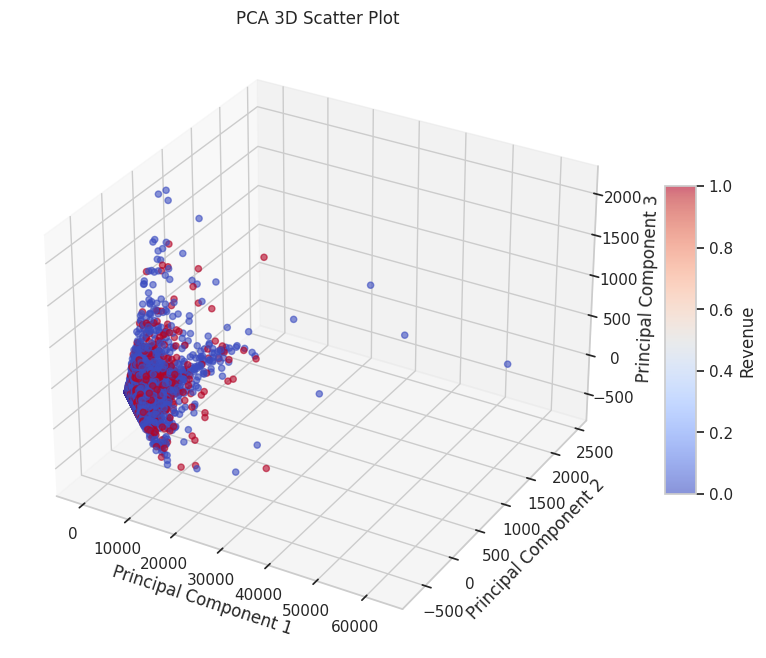

In [225]:
# Perform dimensionality reduction on numerical features and visualize the distribution of the data in the reduced space
pca = PCA(n_components=3)
pca_result = pca.fit_transform(data.select_dtypes(include='number'))

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    pca_result[:, 0],
    pca_result[:, 1],
    pca_result[:, 2],
    c=data['Revenue'],
    cmap='coolwarm',
    alpha=0.6
)

ax.set_title("PCA 3D Scatter Plot")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")

cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=10)
cbar.set_label("Revenue")

plt.show()

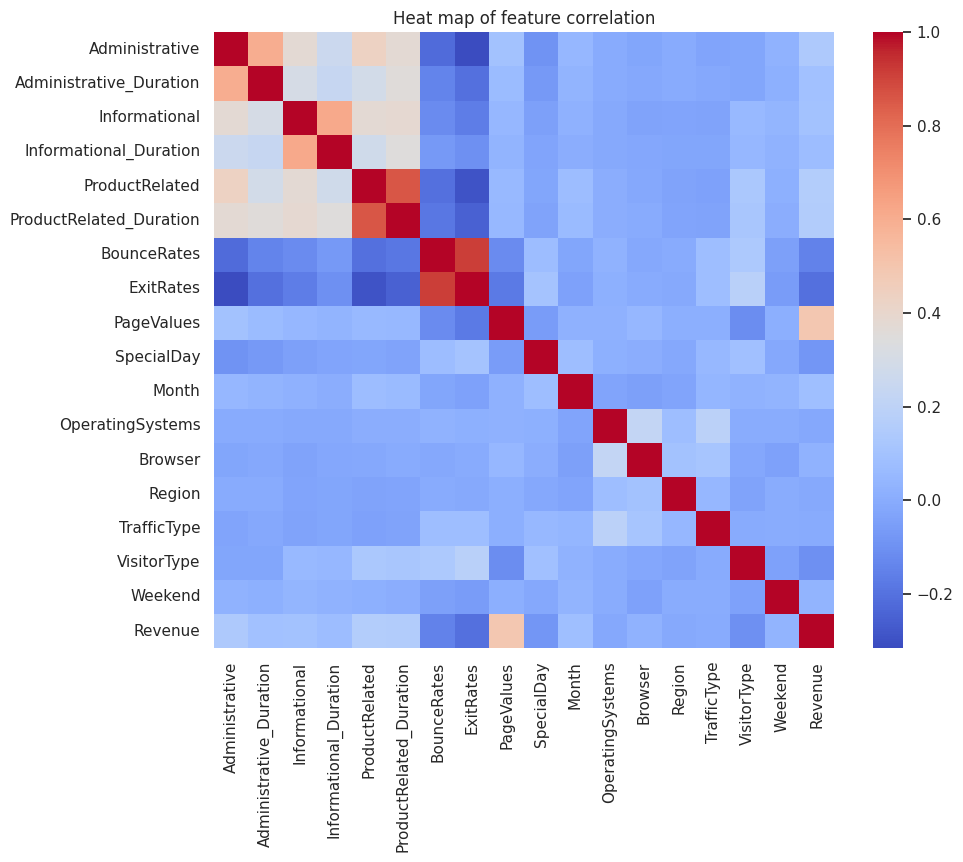

In [226]:
# data visualization: Correlation Heatmap
plt.figure(figsize=(10, 8))
corr = data.corr()
sns.heatmap(corr, annot=False, cmap='coolwarm', fmt='.2f')
plt.title("Heat map of feature correlation")
plt.show()

In [227]:
# Feature selection and engineering
BOUNCE_VALUE = 'Bounce_Value'
MONTH_SIN = 'Month_sin'
MONTH_COS = 'Month_cos'

data = data.drop([BROWSER, TRAFFICTYPE, ADMINISTRATIVE, ADMINISTRATIVE_DURATION], axis=1)
data[BOUNCE_VALUE] = data[PAGEVALUES] * data[BOUNCERATES]
data[MONTH_SIN] = np.sin(2 * np.pi * data[MONTH] / 12)
data[MONTH_COS] = np.cos(2 * np.pi * data[MONTH] / 12)

X = data.drop('Revenue', axis=1)
y = data['Revenue']

# Data set partitioning: training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Oversampling with SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Feature standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [228]:
# define the function of model evaluation
# use default thresholds 0.5
def evaluate_model(model, X_test, y_test, model_name="Model"):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    classify_report = classification_report(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = 0
    if y_proba is not None:
        auc = roc_auc_score(y_test, y_proba)
    confusion = confusion_matrix(y_test, y_pred)

    print("Classification Report: \n", classify_report)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1:  {f1:.4f}")
    print(f"AUC-ROC: {auc:.4f}")
    print("Confusion Matrix: \n", confusion)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    # draw confusion heatmap
    sns.heatmap(confusion, annot=True, fmt="d", cmap="coolwarm", ax=axes[0])
    axes[0].set_title(f"{model_name} -- Confusion Matrix")
    axes[0].set_xlabel("Predicted Revenue")
    axes[0].set_ylabel("Actual Revenue")

    # draw ROC
    print("\n")
    if y_proba is not None:
        fpr, tpr, thresholds = roc_curve(y_test, y_proba)
        axes[1].plot(fpr, tpr, label=f"{model_name} (AUC = {auc:.4f})", color="blue")
        axes[1].plot([0, 1], [0, 1], color='gray', linestyle='--')
        axes[1].set_title(f"{model_name} -- ROC")
        axes[1].set_xlabel("False Positive Rate")
        axes[1].set_ylabel("True Positive Rate")
        axes[1].legend()

    plt.tight_layout()
    plt.show()

In [229]:
# define the function of model evaluation with parameter threshold
# use predefined thresholds
def evaluate_with_threshold(model, X_test, y_test, model_name="Model", threshold=0.5):

    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    if y_proba is None:
        raise ValueError(f"{model_name} does not support probability prediction.")

    y_pred = (y_proba >= threshold).astype(int)

    classify_report = classification_report(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = 0
    if y_proba is not None:
        auc = roc_auc_score(y_test, y_proba)
    confusion = confusion_matrix(y_test, y_pred)

    print(f"\nThreshold: {threshold}")
    print("Classification Report: \n", classify_report)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1:  {f1:.4f}")
    print(f"AUC-ROC: {auc:.4f}")
    print("Confusion Matrix: \n", confusion)

In [230]:
# difine different thresholds to test if we can improve the metrics for taype Purchased
thresholds = [0.6, 0.45, 0.4, 0.3, 0.2]

>>> Model 1：Logistic Regression <<<

Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.88      0.91      3127
           1       0.51      0.69      0.59       572

    accuracy                           0.85      3699
   macro avg       0.73      0.78      0.75      3699
weighted avg       0.87      0.85      0.86      3699

Accuracy: 0.8500
Recall: 0.6888
F1:  0.5867
AUC-ROC: 0.8597
Confusion Matrix: 
 [[2750  377]
 [ 178  394]]




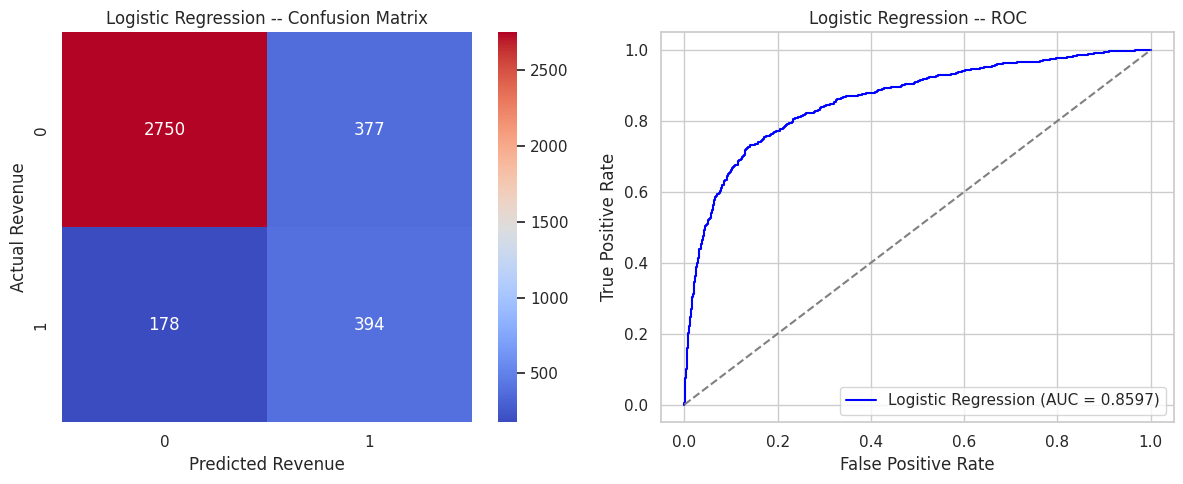

In [231]:
# Model 1：Logistic Regression
print(">>> Model 1：Logistic Regression <<<\n")
logistic_model = LogisticRegression(random_state=42)
logistic_model.fit(X_train, y_train)
evaluate_model(logistic_model, X_test, y_test, model_name="Logistic Regression")

# for threshold in thresholds:
    # evaluate_with_threshold(logistic_model, X_test, y_test, model_name="Logistic Regression", threshold=threshold)

>>> Model 2：RandomForest Classifier <<<

Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.93      0.94      3127
           1       0.64      0.67      0.66       572

    accuracy                           0.89      3699
   macro avg       0.79      0.80      0.80      3699
weighted avg       0.89      0.89      0.89      3699

Accuracy: 0.8916
Recall: 0.6661
F1:  0.6552
AUC-ROC: 0.9091
Confusion Matrix: 
 [[2917  210]
 [ 191  381]]




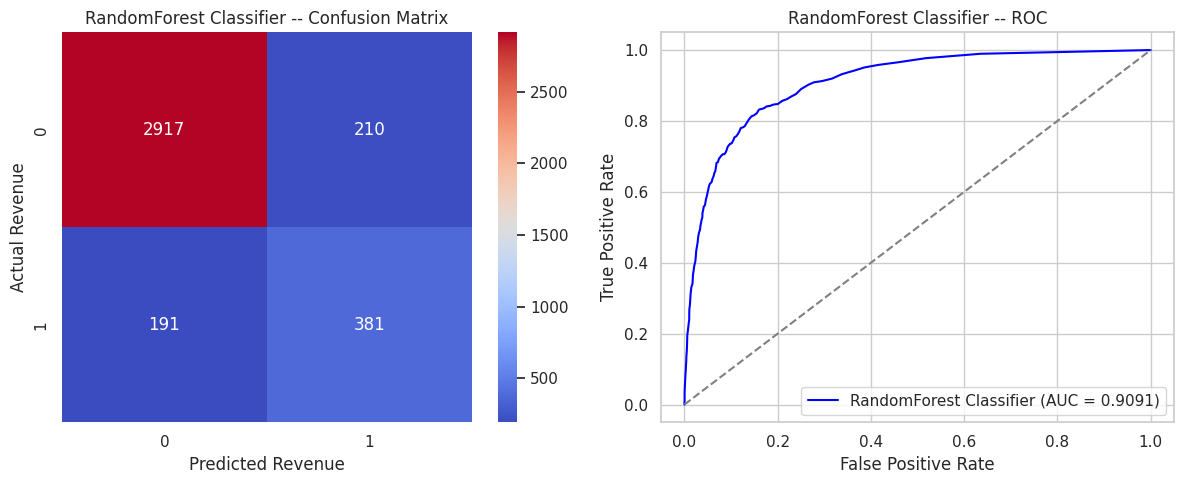

In [232]:
# Model 2：RandomForest Classifier
print(">>> Model 2：RandomForest Classifier <<<\n")
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)
evaluate_model(rf_model, X_test, y_test, model_name="RandomForest Classifier")

# for threshold in thresholds:
    # evaluate_with_threshold(rf_model, X_test, y_test, model_name="RandomForest Classifier", threshold=threshold)

>>> Model 3：XGBClassifier <<<

Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.93      0.94      3127
           1       0.65      0.67      0.66       572

    accuracy                           0.89      3699
   macro avg       0.79      0.80      0.80      3699
weighted avg       0.89      0.89      0.89      3699

Accuracy: 0.8924
Recall: 0.6713
F1:  0.6587
AUC-ROC: 0.9209
Confusion Matrix: 
 [[2917  210]
 [ 188  384]]




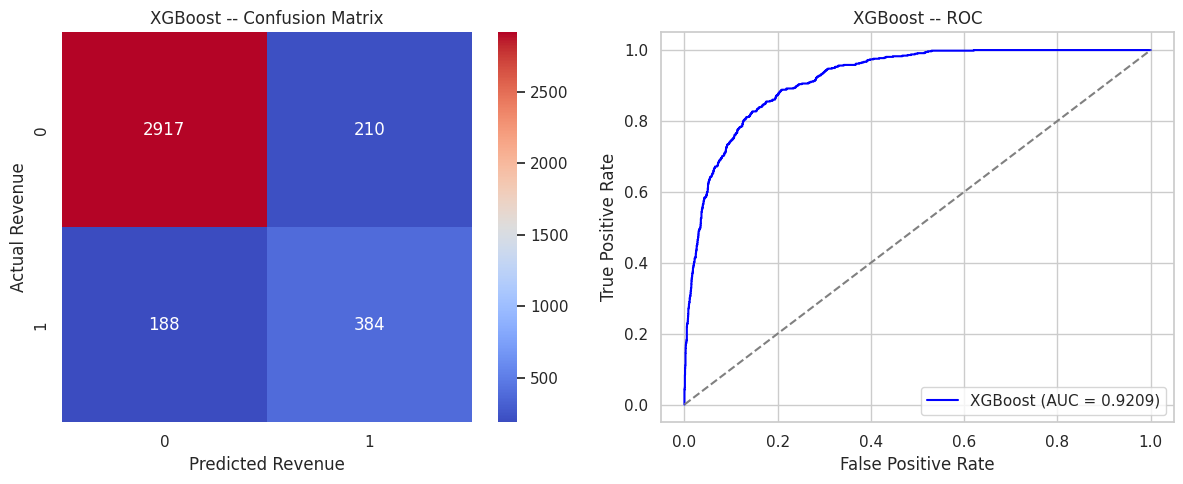

In [233]:
# Model 3：XGBClassifier
print(">>> Model 3：XGBClassifier <<<\n")
xgb_model = XGBClassifier(
    random_state=42,
    scale_pos_weight=1,
    max_depth=5,
    learning_rate=0.1,
    n_estimators=100,
    min_child_weight=3,
    gamma=0.1
)
xgb_model.fit(X_train, y_train)
evaluate_model(xgb_model, X_test, y_test, model_name="XGBoost")

# for threshold in thresholds:
    # evaluate_with_threshold(xgb_model, X_test, y_test, model_name="XGBoost", threshold=threshold)